In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the dataset


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/EFQM/session 5/LSTM-Multivariate_pollution.csv')
data.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


# Checking dataset status


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


# Create Time features

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour


data.drop(['date'], axis=1, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,year,month,day,hour
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010,1,2,0
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010,1,2,1
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010,1,2,2
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010,1,2,3
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010,1,2,4


# create dummy data from wind_dir feature

In [ ]:
dummy_wind = pd.get_dummies(data['wnd_dir'])
data = pd.concat([data, dummy_wind], axis=1)
data.drop(['wnd_dir'], axis=1, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,year,month,day,hour,NE,NW,SE,cv
0,129.0,-16,-4.0,1020.0,1.79,0,0,2010,1,2,0,False,False,True,False
1,148.0,-15,-4.0,1020.0,2.68,0,0,2010,1,2,1,False,False,True,False
2,159.0,-11,-5.0,1021.0,3.57,0,0,2010,1,2,2,False,False,True,False
3,181.0,-7,-5.0,1022.0,5.36,1,0,2010,1,2,3,False,False,True,False
4,138.0,-7,-5.0,1022.0,6.25,2,0,2010,1,2,4,False,False,True,False


# Feature scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = data.drop(['pollution'], axis=1)
y = data['pollution']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

scaled_data = pd.DataFrame(scaled_data)
scaled_data['pollution'] = y
scaled_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,pollution
0,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,1.0,0.0,129.0
1,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,0.033333,0.043478,0.0,0.0,1.0,0.0,148.0
2,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.0,0.0,0.033333,0.086957,0.0,0.0,1.0,0.0,159.0
3,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.0,0.0,0.033333,0.130435,0.0,0.0,1.0,0.0,181.0
4,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.0,0.0,0.033333,0.173913,0.0,0.0,1.0,0.0,138.0


#create a sequence of data

In [ ]:
import numpy as np

X = []
y = []

sequence_length = 16
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data.iloc[i-sequence_length:i].values)
    y.append(scaled_data.iloc[i]['pollution'])

X, y = np.array(X), np.array(y)
X.shape, y.shape

((43784, 16, 15), (43784,))

#Splitting data into train, test and validation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((35027, 16, 15), (4378, 16, 15), (4379, 16, 15))

#Padding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', dtype='float32')
X_val = pad_sequences(X_val, padding='post', dtype='float32')
X_test = pad_sequences(X_test, padding='post', dtype='float32')
X_train.shape, X_val.shape, X_test.shape

((35027, 16, 15), (4378, 16, 15), (4379, 16, 15))

#Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])), # to ignore padding
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - loss: 13358.1768 - val_loss: 7707.2866
Epoch 2/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - loss: 7192.5605 - val_loss: 4628.8789
Epoch 3/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - loss: 4455.3145 - val_loss: 3031.7095
Epoch 4/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - loss: 3167.8582 - val_loss: 2127.9763
Epoch 5/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - loss: 2184.9836 - val_loss: 1549.5394
Epoch 6/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - loss: 1806.2607 - val_loss: 1241.5104
Epoch 7/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 84s 46ms/step - loss: 1424.5797 - val_loss: 1036.5720
Epoch 8/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - loss: 1303.2960 - val_loss: 863.1377
Epoch 9/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - loss: 1106.4124 - val_loss: 788.7590
Epoch 10/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - loss: 956.9044 - val_loss: 767.9455
Epoch 11/32
1095/1095 ━━━━━━━━━━━━━━━━━━━━

# Model Information

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 16, 15)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16, 128)             │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,605 (1.41 MB)

 Trainable params: 123,201 (481.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 246,404 (962.52 KB)

#Model Training Plot

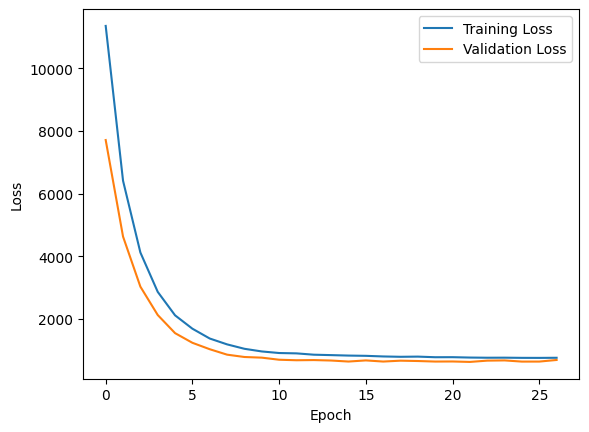

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Evaluation

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

y_pred = model.predict(X_test)
y_test.shape, y_pred.shape

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 926.1182
Test Loss: 847.7416381835938
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


((4379,), (4379, 1))

#Plot Test Predictions

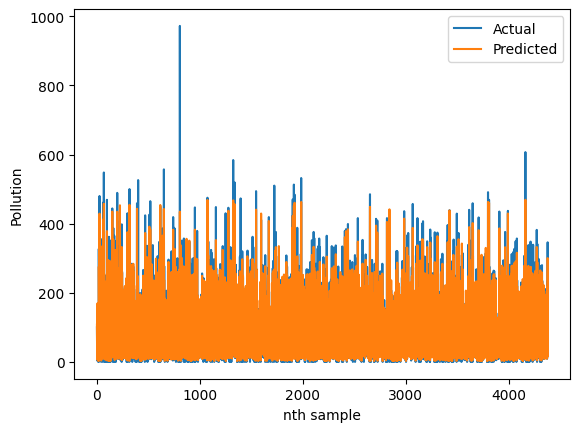

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('nth sample')
plt.ylabel('Pollution')
plt.legend()